In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
from sklearn import metrics

from diffusion_functions import *
from semi_supervised_manifold_learning import *
from debugging_animation import animate_hgraph_diffusion, animate_graph_diffusion

# commands for displaying animations in jupyter notebook
from IPython.display import HTML

%load_ext autoreload
%autoreload 2

# Visualization code

In [3]:
def plot_label_comparison_binary(ax, label_vector, data_matrix, titlestring=None):
    error, threshold = find_min_sweepcut(label_vector,100,sweep_cut_classification_error)
    label_estimates = make_sweep_cut(label_vector, threshold)
    #pdb.set_trace()
    error = sweep_cut_classification_error(label_estimates)
    im = ax.scatter(data_matrix[:,0],data_matrix[:,1], c=label_estimates.reshape(-1))
    #im = ax.scatter(data_matrix[:,0],data_matrix[:,1], c=label_vector)
    
    # figure formatting
    ax.set_aspect('equal')
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.axis('off')
    if titlestring=='Abridged':
        ax.set_title(f'Classification error = {error:.3f}', fontsize = 15)
    else:
        ax.set_title(titlestring +f'\n Classification error = {error:.3f}', fontsize = 15)
    return

def final_plot_AUC_hist(AUC_vals, ax, decorated = False, titlestring = None):
    plt.rcParams.update({'font.size': 15})
        
    hypergraph_vals = [v[0] for v in AUC_vals]
    graph_vals = [v[1] for v in AUC_vals]
    
    full_values = hypergraph_vals+graph_vals
    _, first_bins = np.histogram(full_values, bins = 10)

    # second style
    ax.hist(graph_vals, bins = first_bins, alpha=0.5, edgecolor = 'black', label = 'graph')
    ax.hist(hypergraph_vals, bins = first_bins, alpha=0.5, edgecolor = 'black', label='hypergraph')
    
    if decorated:
        #ax.set_title(f'AUC Values at Iteration 50 \n Results from 50 Independent Trials')
        ax.legend()
        
    # figure formatting
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    
    if not (titlestring is None):
        ax.set_title(titlestring)
    return

# Single instance

Using degree regularizer


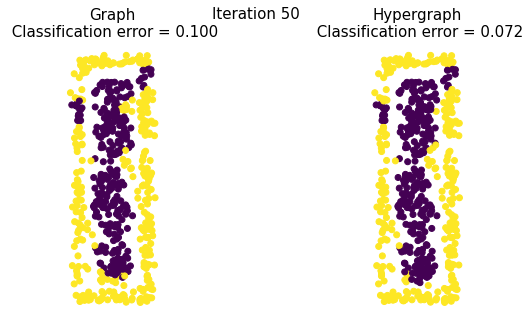

In [6]:
k = 5
target_iternum = 50
titlestring = 'blah'

fig_binary, ax_binary = plt.subplots(nrows=1, ncols=2,figsize=(10, 5))

data_generation, problem_kind  = (generate_concentric_rectangles,'rectangles')
#(generate_overlapping_rings,'Rings')
#(generate_spirals,' Spirals')
    
graph_x_out, hypergraph_x_out, data_matrix = compare_estimated_labels('PPR',
                                                                      data_generation,
                                                                      k,
                                                                      target_iternum,
                                                                      titlestring=None, 
                                                                      diffusion_step_size=1,
                                                                      node_weight_method= 'gaussian_to_central_neighbor')

for idx,(x,titlestring) in enumerate([(graph_x_out,'Graph'), (hypergraph_x_out,'Hypergraph')]):
    plot_label_comparison_binary(ax_binary[idx],x, data_matrix,titlestring)

plt.suptitle(f'Iteration {target_iternum}', fontsize = 15)    
plt.show()

# Animate Weighted Diffusion

/Users/adeladepavia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
/Users/adeladepavia/Documents/GitHub/hypergraph_diffusions/semi_supervised_manifold_learning.py:933: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
/Users/adeladepavia/Documents/GitHub/hypergraph_diffusions/semi_supervised_manifold_learning.py:933: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


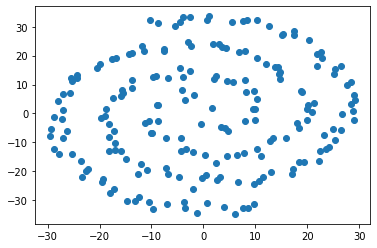

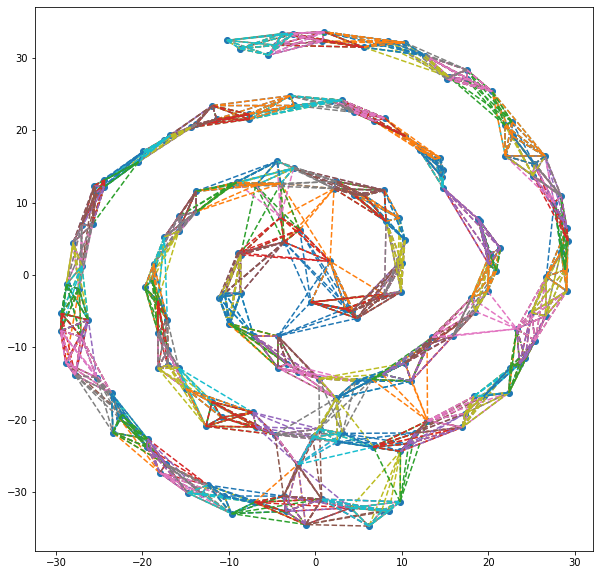

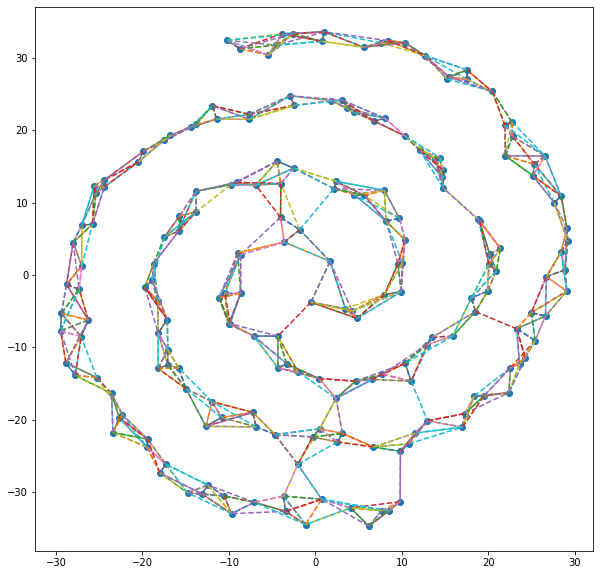

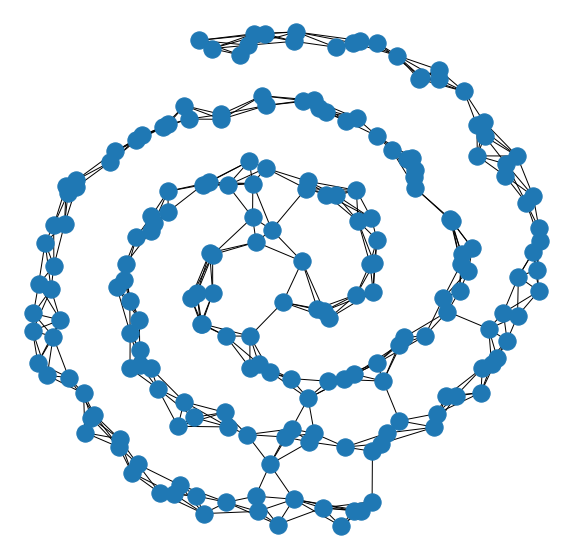

In [121]:
# generate new data
_, data_matrix = generate_spirals(n_pts=100, verbose = False) #start_theta=np.pi / 5, num_rotations=0.9, verbose=False)

# build a hypergraph from k-nearest-nbs of each point
k = 5
knn_hgraph_dict = build_knn_hypergraph(data_matrix, k)
n = knn_hgraph_dict['n']

star_hgraph_dict = build_knn_hypergraph_star_expansion(data_matrix, k)

knn_adj_matrix = build_knn_graph(data_matrix, k)
D = np.squeeze(np.asarray(np.sum(knn_adj_matrix,axis=0)))
G = nx.from_scipy_sparse_matrix(knn_adj_matrix)
pos = dict([(v,data_matrix[v,:]) for v in G.nodes()])

plt.scatter(data_matrix[:, 0], data_matrix[:, 1])
plt.show()

visualize_hyperedges(data_matrix, knn_hgraph_dict['hypergraph'])
visualize_hyperedges(data_matrix, star_hgraph_dict['hypergraph'])

fig, ax = plt.subplots(figsize = (10,10))
nx.draw(G, pos = pos, ax = ax)

# sample a random initial seed node
# x0 = np.full(shape=(n, 1), fill_value=0)
# x0[np.random.choice(n, size = 1)] = 1

# create an initial pt with num_rand_seeds randomly chosen true labels
x0 = np.full(shape=(n, 1), fill_value=0)
num_rand_seeds = 10
random_seeds = np.random.choice(np.arange(n), size=num_rand_seeds)
x0[random_seeds[random_seeds < n / 2]] = -1
x0[random_seeds[random_seeds > n / 2]] = 1

In [122]:
ani = animate_hgraph_diffusion(data_matrix, 
                               star_hgraph_dict,
                               x0,
                               node_weight_method='gaussian_to_centroid',
                              hypergraph_name = '2 hypergraph, gaussian centroid weights')

HTML(ani.to_html5_video())

Using degree regularizer


In [20]:
ani = animate_hgraph_diffusion(data_matrix,
                               knn_hgraph_dict,
                               x0,
                               node_weight_method=None,
                               hypergraph_name = '5 knn, uniformly weighted nodes')

HTML(ani.to_html5_video())

Using degree regularizer


In [34]:
node_weight_method='gaussian_to_central_neighbor'
ani = animate_hgraph_diffusion(data_matrix,
                               knn_hgraph_dict,
                               x0,
                               node_weight_method=node_weight_method,
                               hypergraph_name = '5 knn, '+node_weight_method+'\n bandwidth = 1')

HTML(ani.to_html5_video())

Using degree regularizer


In [10]:
ani = animate_hgraph_diffusion(data_matrix, star_hgraph_dict, x0, node_weight_method=None)

HTML(ani.to_html5_video())

Using degree regularizer


# Scrap Code

Using degree regularizer
Using degree regularizer
Using degree regularizer
Using degree regularizer
Using degree regularizer
Using degree regularizer
Using degree regularizer
Using degree regularizer
Using degree regularizer
Using degree regularizer
Using degree regularizer
Using degree regularizer
Using degree regularizer
Using degree regularizer
Using degree regularizer
Using degree regularizer
Using degree regularizer
Using degree regularizer
Using degree regularizer
Using degree regularizer
Using degree regularizer
Using degree regularizer
Using degree regularizer
Using degree regularizer
Using degree regularizer
Using degree regularizer
Using degree regularizer
Using degree regularizer
Using degree regularizer
Using degree regularizer
Using degree regularizer
Using degree regularizer
Using degree regularizer
Using degree regularizer
Using degree regularizer
Using degree regularizer
Using degree regularizer
Using degree regularizer
Using degree regularizer
Using degree regularizer


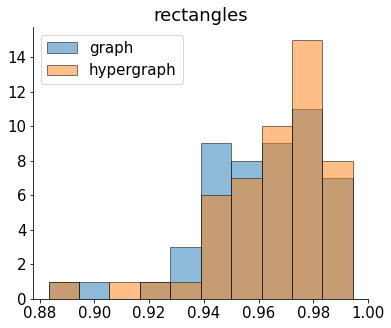

In [7]:
fig, ax = plt.subplots(figsize = (6, 5))
AUC_vals = []
num_trials = 50

# generate dummy data to extract default n value
_,data_matrix = data_generation(verbose=False)
n = data_matrix.shape[0]
labels = np.hstack([np.full(shape=int(n/2),fill_value = -1),np.full(shape=int(n/2),fill_value = 1)])

for trial in range(num_trials):
    # cluster via PPR computation
    graph_x_out, hypergraph_x_out, data_matrix = compare_estimated_labels('PPR',
                                                                          data_generation,
                                                                          k,
                                                                          target_iternum,
                                                                          titlestring=None, 
                                                                          diffusion_step_size=1,
                                                                          node_weight_method= 'gaussian_to_central_neighbor')
    graph_auc_score = metrics.roc_auc_score(labels, graph_x_out)
    hypergraph_auc_score = metrics.roc_auc_score(labels, hypergraph_x_out)

    AUC_vals.append((hypergraph_auc_score, graph_auc_score))
final_plot_AUC_hist(AUC_vals, ax = ax, decorated = True, titlestring = problem_kind )